# Finding rought $T_g$

Find some good simulation statepoints for the MLJ potential

(83.14286109193095, 0.0004586032305547224)

Current good statepoints

| $\Delta$    | $\rho$      | $T_{low}$ | $T_{high}$| $D_{low}$ | $D_{high}$ | $\alpha_{low}$ | $\alpha_{high}$ |
| ----------- | ----------- | --------- | --------- | --------- | ---------- | -------------- | --------------- |
| 0.0         | 1.2         | 0.5       | 1.5       | 0.00025   | 0.0328     | 96.4           | 0.508           |
| 0.1         | 1.15        | 0.55      | 1.7       | 0.00037   | 0.0338     | 57.3           | 0.486           |
| 0.2         | 1.1         | 0.55      | 1.8       | 0.00028   | 0.0319     | 75.1           | 0.509           |
| 0.3         | 1.05        | 0.55      | 2.0       | 0.00038   | 0.0327     | 52.7           | 0.493           |
| 0.4         | 1.0         | 0.55      | 2.1       | 0.00077   | 0.0315     | 23.0           | 0.509           |
| 0.5         | 0.95        | 0.4       | 2.2       | 0.00039   | 0.0316     | 54.4           | 0.510           |
| 0.6         | 0.9         | 0.39      | 2.3       | 0.00045   | 0.0328     | 83.14          | 0.496           |

Other measurements, with less crazy densities

Need to be careful with these parameters, it can be quite easy to re-trigger crystallization as the reach of the attractive piece of the interaction is shortened

Keeping the volume factions (and pressures) high keep the nearest neighbors well onto the repulsive piece of the potential, and allow for some next-nearest neighbors to feel the attractive portion

(0.44684212648701904, 0.03730033271428708)

| $\Delta$  | $\rho$    | $T$   | $D$       | $\tau_\alpha$ |
| --------- | --------- | ----- | --------- | ------------- |
| 0.1       | 1.18      | 2.0   | 3.73e-2   | 0.44          |
| 0.2       | 1.16      | 2.0   | 2.22e-2   | 0.65          |
| 0.3       | 1.14      | 2.0   | 1.14e-2   | 1.25          |
| 0.4       | 1.12      | 4.0   | 2.57e-2   | 0.57          |
| 0.5       | 1.2       | 7.0   | 2.46e-3   | 7.74          |
| 0.5       | 1.1       | 4.0   | 8.06e-3   | 1.74          |
| 0.5       | 1.0       | 4.0   | 4.21e-2   | 0.38          |

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac

In [2]:
from monk import nb, prep, pair, render
import freud

When running simulations, we can't be sure the system is equilibrated until we observe consistent behaviour in the alpha relaxation beavior. Additionally, once the alpha relaxation has settled in on a steady value, we should wait at least a decade in the alpha relaxation timescale before collecting data.

In [3]:


class VerifyEquilibrium(hoomd.custom.Action):
    """Computes dynamics to verify equilibration."""

    def __init__(self, k: float = None):
        self.last_pos = None
        self.last_image = None
        self.last_tstep = None
        self.k = 7.14
        self.alphas = []
        self.Ds = []
        # self.msds = []
        # self.tsteps = []
    
    def act(self, timestep):
        snap = self._state.get_snapshot()
        if self.last_pos is None:
            self.last_pos = snap.particles.position
            self.last_image = snap.particles.image
            self.first_tstep = timestep
            self.last_tstep = timestep
            self.last_msd = 0.0
            self.alpha_time = 0.0
            self.measure_D = False
            self.measured_D = 0.0
            self.measured_alpha = 0.0
        else:
            dt = self._state._simulation.operations.integrator.dt
            pos = snap.particles.position
            image = snap.particles.image
            sim_box = self._state.box
            if sim_box.is2D:
                dim = 2
            else:
                dim = 3
            box = freud.box.Box.from_box(sim_box)
            unwrapped_pos = box.unwrap(pos, image - self.last_image)
            msd = np.mean(np.sum(np.square(unwrapped_pos - self.last_pos), axis=-1))
            if self.measure_D:
                if (timestep - self.last_tstep)*dt > self.measured_alpha:
                    # self.msds.append(msd)
                    # self.tsteps.append(timestep - self.first_tstep)
                    D = (msd - self.last_msd) / (timestep - self.last_tstep) / dt / (2 * dim)
                    self.measured_D = D
                    self.Ds.append(self.measured_D)
                    self.alphas.append(self.measured_alpha)
                    print(f"D = {self.measured_D}    alpha = {self.measured_alpha}")
                    self.measure_D = False
                    self.alpha_time = 0.0
                    self.first_tstep = timestep
                    self.last_pos = snap.particles.position
                    self.last_image = snap.particles.image
            else:
                self.last_tstep = timestep
                self.last_msd = msd

                # self.msds.append(msd)
                # self.tsteps.append(timestep - self.first_tstep)

                x = self.k * np.linalg.norm(pos - self.last_pos, axis=-1)
                sisf = np.mean(np.sin(x)/x)

                # print(f"{D} {sisf}")

                self.alpha_time = (timestep - self.first_tstep) * dt
                if sisf < np.exp(-1.0):
                    self.measure_D = True
                    self.measured_alpha = self.alpha_time
            


In [4]:
N = 2**15

In [29]:
N

32768

In [139]:
sim = prep.quick_sim(N, 0.95, hoomd.device.GPU(), ratios=[80, 20], diams=[1.0, 0.88])

render.render_sphere_frame(sim.state.get_snapshot())

In [140]:
temp = 1.0
end_temp = 0.01
speed = 1e-2
steps = int(1_000*(temp-end_temp)/speed)
steps = 400_000
p = 1.0
delta = 0.75

eq_steps = 10_000

integrator = hoomd.md.Integrator(dt=0.001)
tree = hoomd.md.nlist.Tree(0.3)
mlj = pair.KA_ModLJ(tree, delta)
# variant = hoomd.variant.Ramp(temp, end_temp, sim.timestep + eq_steps, steps)
variant = 5.0
# nvt = hoomd.md.methods.NPT(hoomd.filter.All(), variant, 1.0, p, 1.0, "xyz", gamma=1.0)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), variant, 0.1)
integrator.forces = [mlj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

# sim.always_compute_pressure = True

sim.state.thermalize_particle_momenta(hoomd.filter.All(), 2.0)

sim.run(0)
# nvt.thermalize_thermostat_dof()

# file = open(f'_log_quench-test_rate-{speed}_p-{p}_d-{delta}.log', mode='w', newline='\n')
# table = hoomd.write.Table(hoomd.trigger.Periodic(1_000), output=file, logger=log)



In [141]:
sim.run(100_000)

In [50]:
nvt.kT(sim.timestep)

4.0

In [53]:
nvt.kT = 7.0

In [77]:
sim.always_compute_pressure = True

In [144]:
# log = hoomd.logging.Logger(categories=["scalar"])
analyzer = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.clear()
sim.operations.computes.append(analyzer)
# log.add(analyzer)

writer = hoomd.write.GSD(hoomd.trigger.Periodic(1_000), f"test-params.gsd", mode="wb")
sim.operations.writers.clear()
sim.operations.writers.append(writer)
# sim.operations.writers.append(table)

In [79]:
analyzer.pressure

1.2123793363571167

In [76]:
sim.operations.updaters.clear()

In [145]:
sim.run(100_000)

D = 0.004368508457806212    alpha = 7.160000340081751
D = 0.004719161575685806    alpha = 8.430000400403515
D = 0.003795817544694677    alpha = 12.180000578518957


In [114]:
delta, nvt.kT(sim.timestep)

(0.4, 4.0)

In [142]:
action = VerifyEquilibrium()
custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(10), action)
sim.operations.updaters.clear()
sim.operations.updaters.append(custom_action)

# nvt.kT = 0.5

In [74]:
nvt.kT = nvt.kT(sim.timestep) * .9
print(nvt.kT(sim.timestep))
sim.run(200_000)

1.0628819465637207
D = 0.0008706231910546115    alpha = 15.00000071246177
D = 0.0004911123932192196    alpha = 32.00000151991844
D = 0.00043087032116902467    alpha = 44.00000208988786


render.render_sphere_frame(sim.state.get_snapshot())

In [80]:
sim.run(1_000_000)

D = 0.00039442197012877055    alpha = 68.00000322982669
D = 0.0004084123175786597    alpha = 50.000002374872565
D = 0.0004348974408929485    alpha = 54.00000256486237
D = 0.0004297189219516281    alpha = 51.00000242237002
D = 0.00038487055071936745    alpha = 55.00000261235982
D = 0.00042121296131605624    alpha = 61.00000289734453
D = 0.00035570950002451084    alpha = 56.00000265985727
D = 0.00038934918703032844    alpha = 66.00000313483179
D = 0.000427186477897358    alpha = 55.00000261235982


In [76]:
print(nvt.kT(sim.timestep))

1.0628819465637207


In [59]:
len(action.alphas)

28

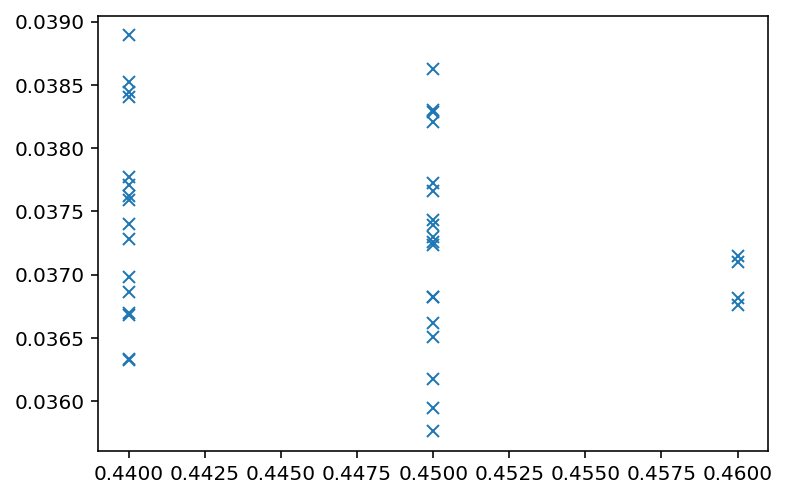

In [126]:
lim = 7
plt.plot(action.alphas[lim:], action.Ds[lim:], "x")
# plt.yscale('log')
# plt.xscale('log')

In [127]:
np.mean(action.alphas[lim:]), np.mean(action.Ds[lim:])

(0.44684212648701904, 0.03730033271428708)

In [42]:
plt.plot(action.tsteps, action.msds, ".", linestyle="")

AttributeError: 'VerifyEquilibrium' object has no attribute 'tsteps'

In [162]:
gc.collect()

682

In [ ]:
quench_params = {
    0.0: {
        1.5
    }
}

## Potential form

What does this look like again for different $\Delta$ values?

In [101]:
def mlj(r, delta):
    sigma = 1 - delta*2**(-1/6)
    term = sigma/(r - delta)
    return 4 * (term**12 - term**6)

Text(0.5, 0, '$r$')

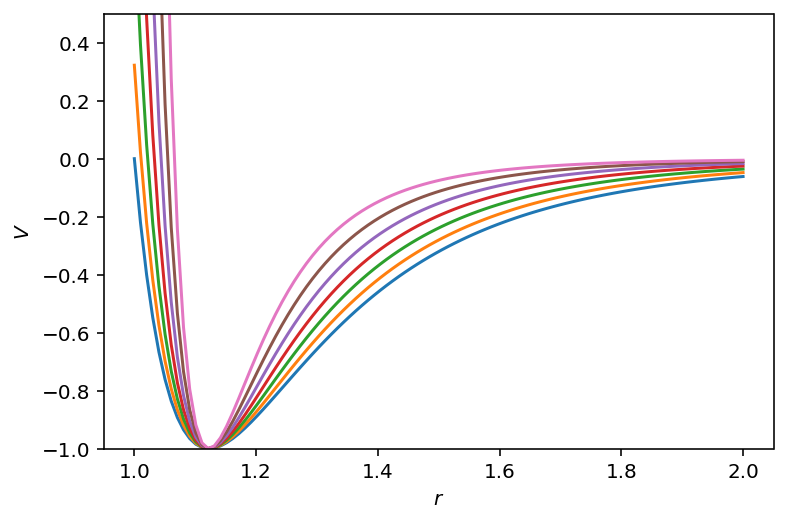

In [102]:
x = np.linspace(1.0, 2.0, 100)

for d in np.linspace(0.0, 0.6, 7):
    plt.plot(x, mlj(x, d))

plt.ylim(-1, 0.5)
plt.ylabel(r"$V$")
plt.xlabel(r"$r$")

## Inspect logs

In [150]:
logs = glob.glob("_log_*p-1.0*.log")

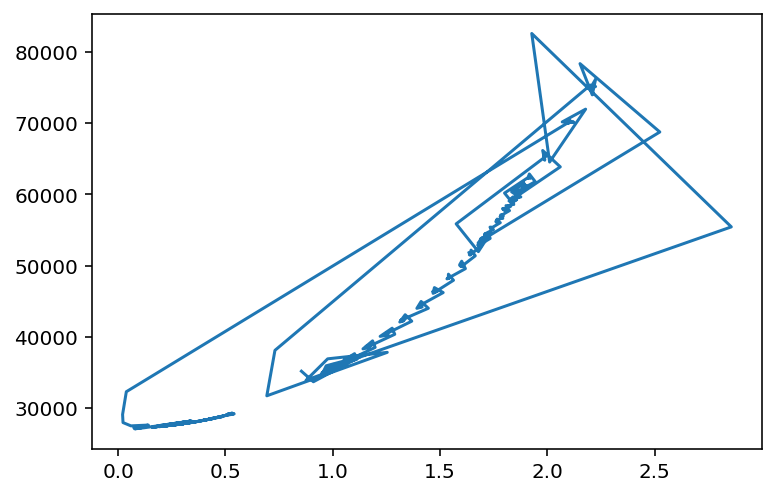

In [152]:
label = 2

for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    l, = plt.plot(df["md.compute.ThermodynamicQuantities.kinetic_temperature"], df["md.compute.ThermodynamicQuantities.volume"])
# plt.yscale('log')
# plt.xscale('log')

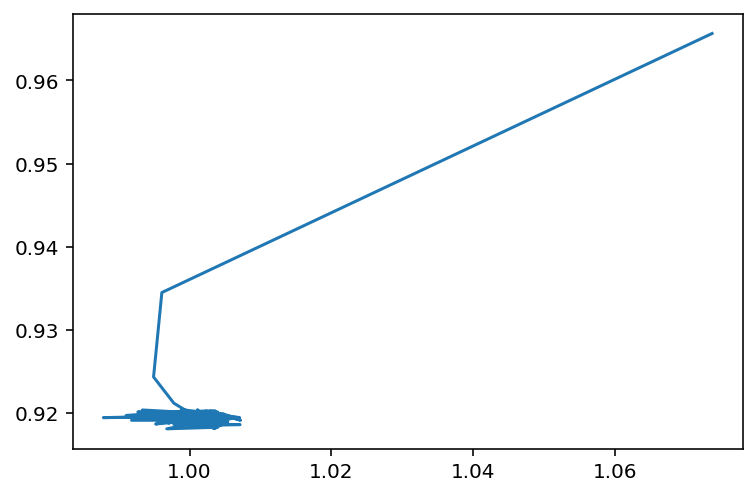

In [85]:
label = 2

for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    l, = plt.plot(df["md.compute.ThermodynamicQuantities.kinetic_temperature"], N/df["md.compute.ThermodynamicQuantities.volume"])

In [86]:
logs

['_log_quench-test_rate-0.01_p-1.0_d-0.0.log']

_log_quench-test_rate-0.1_p-50.0_speed-0.1.log 1.5950672669701398
_log_quench-test_rate-0.01_p-50.0_speed-0.01.log 1.5769634525066683


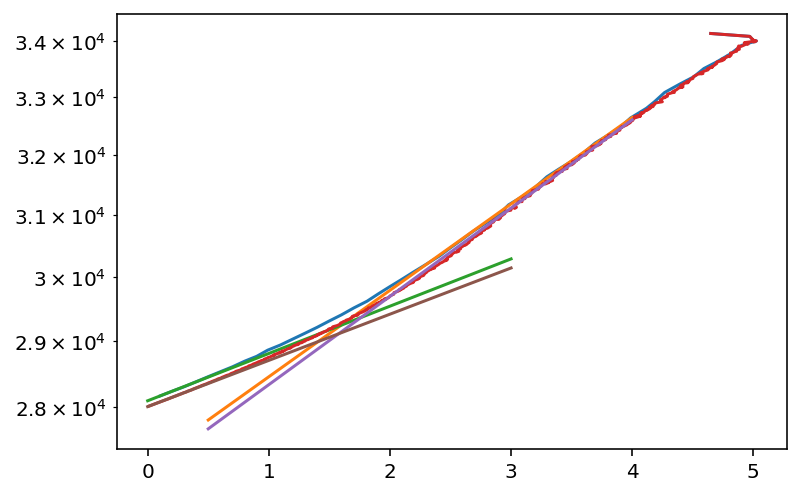

In [105]:
for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    x = df["md.compute.ThermodynamicQuantities.kinetic_temperature"]
    y = df["md.compute.ThermodynamicQuantities.volume"]
    plt.plot(x, y)

    cond = np.logical_and(x < 4.0, x > 3.0)
    fit = np.polyfit(x[cond], np.log(y[cond]), 1)
    xd = np.linspace(.5, 4.0, 100)
    plt.plot(xd, np.exp(xd*fit[0] + fit[1]))


    cond = x < 0.3
    fit2 = np.polyfit(x[cond], np.log(y[cond]), 1)
    xd = np.linspace(0.0, 3.0, 100)
    plt.plot(xd, np.exp(xd*fit2[0] + fit2[1]))

    print(log_file, (fit[1] - fit2[1])/(fit2[0] - fit[0]))

plt.yscale('log')